# Part 1
---

In [73]:
#Import and configure
%matplotlib inline
import cv2
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 13.0)    #adjust plotted images size

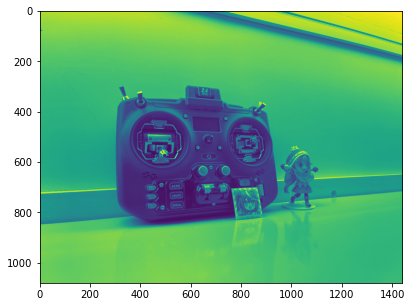

In [74]:
# Load images
img_left_dist = cv2.imread('F-matrix/hw_l.jpg', 0)
img_right_dist = cv2.imread('F-matrix/hw_r.jpg', 0)
img_left_dist = cv2.resize(img_left_dist, (1440,1080))
img_right_dist = cv2.resize(img_right_dist, (1440,1080))

plt.figure(figsize = (10, 5))
plt.imshow(img_left_dist)

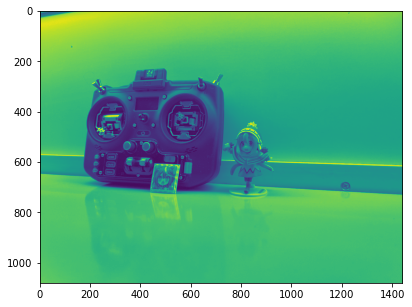

In [75]:
plt.figure(figsize = (10, 5))
plt.imshow(img_right_dist)

In [76]:
def feature_matching(threshold, img_left, img_right):
    '''
    Input:
    img_left - An image read by OpenCV's imread
    img_right - An image read by OpenCV's imread
    
    Output:
    points_left - array of tuples. Each tuple is a coordinate on the left image.
    points_right - array of tuples. Each tuple is a coordinate on the right image.
    '''
    # generate SIFT feature
    feature_detector = cv2.SIFT_create()
    keypoints_left, descriptors_left = feature_detector.detectAndCompute(img_left, None)
    keypoints_right, descriptors_right = feature_detector.detectAndCompute(img_right, None)

    # construct BFMatcher
    bf_matcher = cv2.BFMatcher()
    matches = bf_matcher.knnMatch(descriptors_left,descriptors_right, k=2)

    # apply ratio test
    good_matches = []
    for best, second in matches:
        if best.distance < threshold*second.distance:
            # here we are converting it to a list to do visualization. 
            # I'm not sure why we need this but not doing so will make visualization fail
            good_matches.append([best]) 


    # convert OpenCV's special match class to regular array
    points_left = []
    points_right = []
    for best in good_matches:
        points_left.append(keypoints_left[best[0].queryIdx].pt)
        points_right.append(keypoints_right[best[0].trainIdx].pt)


    # some visualization
    img_matches = cv2.drawMatchesKnn(img_left, keypoints_left,
                                     img_right,keypoints_right,
                                     good_matches[:10],None,
                                     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize = (20, 10))
    plt.imshow(img_matches)
    return points_left, points_right

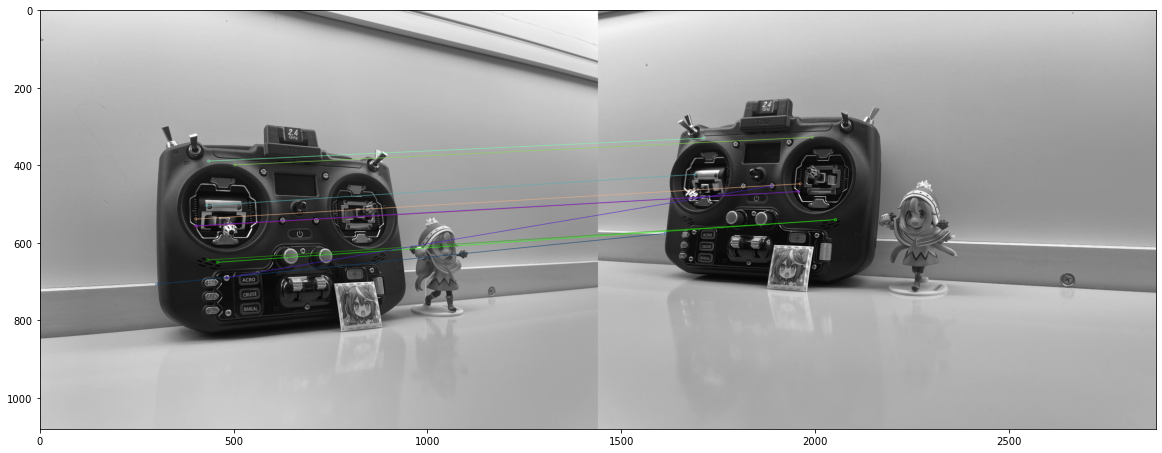

In [77]:
points_left_dist, points_right_dist = feature_matching(0.7, img_left_dist, img_right_dist)

In [78]:
ptsLeft = np.int32(points_left_dist)
ptsRight = np.int32(points_right_dist)
F, mask = cv2.findFundamentalMat(ptsLeft,
                                 ptsRight,
                                 cv2.FM_LMEDS)
  
# We select only inlier points
ptsLeft_dis = ptsLeft[mask.ravel() == 1]
ptsRight_dis = ptsRight[mask.ravel() == 1]

In [81]:
print(F)

[[-1.60624539e-07  2.99334520e-06 -1.28905686e-03]
 [ 3.63548130e-06 -1.31905471e-06 -1.17668973e-02]
 [-1.82787570e-03  8.63995741e-03  1.00000000e+00]]


In [79]:
def drawlines(img1, img2, lines, pts1, pts2):
    
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
      
    for r, pt1, pt2 in zip(lines, pts1[:60], pts2[:60]):
          
        color = tuple(np.random.randint(0, 255,
                                        3).tolist())
          
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, 
                     [c, -(r[2] + r[0] * c) / r[1] ])
          
        img1 = cv2.line(img1, 
                        (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1,
                          tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, 
                          tuple(pt2), 5, color, -1)
    return img1, img2

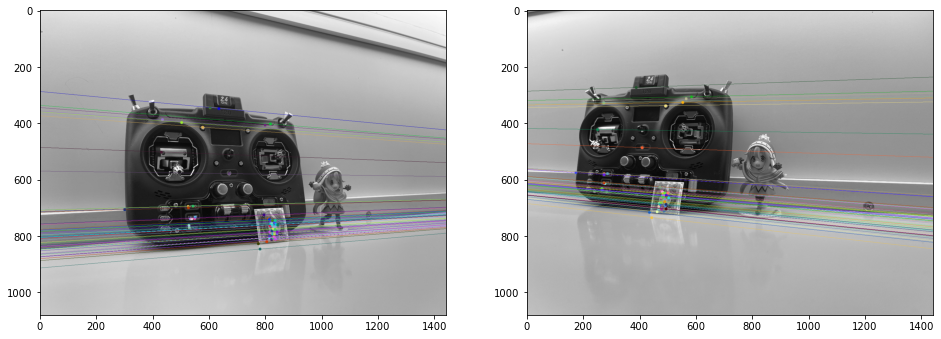

In [80]:
# Find epilines corresponding to points
# in right image (second image) and
# drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight_dis.reshape(-1,
                                                           1,
                                                           2),
                                          2, F)
linesLeft = linesLeft.reshape(-1, 3)
img5, img6 = drawlines(img_left_dist, img_right_dist, 
                       linesLeft, ptsLeft_dis,
                       ptsRight_dis)
   
# Find epilines corresponding to 
# points in left image (first image) and
# drawing its lines on right image
linesRight = cv2.computeCorrespondEpilines(ptsLeft_dis.reshape(-1, 1, 2), 
                                           1, F)
linesRight = linesRight.reshape(-1, 3)
  
img3, img4 = drawlines(img_right_dist, img_left_dist, 
                       linesRight, ptsRight_dis,
                       ptsLeft)
   
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()